In [319]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

pd.set_option('display.width',1000)

In [320]:
def reset_random():
    random.seed(42)
    np.random.seed(42)

## Data generation

In [321]:
def generate_weights_and_values(num_items, weight_range, value_range):
    reset_random()
    weights = np.round(np.random.uniform(*weight_range, num_items), 1)
    values = np.random.randint(*value_range, num_items)
    return pd.DataFrame({
        'weight': weights,
        'value': values
    })

df_addresses = pd.read_csv("full_addresses.csv")
df = generate_weights_and_values(len(df_addresses), (1, 10), (1, 10 + 1))
df = df.join(df_addresses)
df_20 = df.head(20)

print(df_20)

    weight  value                 address_line_1                   city  postcode   latitude  longitude
0      4.4      8                  24 Tulse Hill               Trafford   M33 3QJ  53.415312  -2.323838
1      9.6      4             1 Stanley Cottages   Kingston upon Thames   KT1 2TW  51.401676  -0.299031
2      7.6      1              7 Ashburnham Road               Knowsley   L36 0UX  53.406642  -2.831767
3      6.4      8              17 Bordale Avenue                 Rother  TN39 4HR  50.847934   0.457265
4      2.4      4                  3 Curlew Walk             Mid Sussex  RH17 6EG  51.040337  -0.184974
5      2.4      6  The Rectory, Westerfield Road              Wakefield   WF4 6AD  53.659867  -1.560271
6      1.5      8             50 Mendip Crescent         East Hampshire  GU10 5NH  51.187384  -0.887036
7      8.8      4             26 Timberley Drive             West Devon  PL19 9NS  50.579121  -4.098659
8      6.4      3                     4 Oaklands             Cal

## Genetic Algorithm

### Pure python implementation

In [322]:
def genetic_algorithm(df, max_weight=30, population_size=100, num_generations=50, mutation_rate=0.5):
    reset_random()
    weights = df["weight"].tolist()
    values = df["value"].tolist()
    n = len(values)
    
    # Normalise mutations, so that longer lists dont become more mutated.
    mutation_rate /= n

    average_weight = sum(weights) / n
    expected_items = max_weight / average_weight
    bit_flip_probability = expected_items / n

    # Initialise the population so that each individual has roughly the correct weight
    population = [[1 if random.random() < bit_flip_probability else 0 for _ in range(n)]
                  for _ in range(population_size)]
    
    def get_total_value(individual):
        return sum(value if individual[i] else 0 for i, value in enumerate(values))
    
    def get_total_weight(individual):
        return sum(weight if individual[i] else 0 for i, weight in enumerate(weights))

    def fitness(individual):
        total_weight = get_total_weight(individual)
        total_value = get_total_value(individual)
        if total_weight > max_weight:
            return 0
        return total_value

    def tournament_selection(population, k=3):
        return max(random.sample(population, k), key=fitness)

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        return parent1[:crossover_point] + parent2[crossover_point:], parent2[:crossover_point] + parent1[crossover_point:]

    def mutate(individual):
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = 1 - individual[i] # Flip bit
        return individual

    for _ in range(num_generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            offspring1, offspring2 = crossover(parent1, parent2)
            new_population.append(mutate(offspring1))
            new_population.append(mutate(offspring2))
        population = new_population

    best = max(population, key=fitness)
    return df[[bool(bit) for bit in best]], get_total_value(best), get_total_weight(best)


In [323]:
def show_genetic_algorithm(df, n_runs=4,
                           population_size=100, num_generations=50, mutation_rate=0.2):
    for _ in range(n_runs):
        items, value, weight = genetic_algorithm(df, population_size=population_size, num_generations=num_generations, mutation_rate=mutation_rate)
        print(f"Items: {', '.join(map(str, items.index.tolist()))}")
        print(f"Total weight: {weight:.1f}")
        print(f"Total value: {value}")
        print()


In [324]:
show_genetic_algorithm(df_20)

Items: 0, 4, 5, 6, 9, 10, 15, 17
Total weight: 27.7
Total value: 53

Items: 0, 4, 5, 6, 9, 10, 15, 17
Total weight: 27.7
Total value: 53

Items: 0, 4, 5, 6, 9, 10, 15, 17
Total weight: 27.7
Total value: 53

Items: 0, 4, 5, 6, 9, 10, 15, 17
Total weight: 27.7
Total value: 53



In [325]:
ga_time_python = %timeit -o genetic_algorithm(df)

430 ms ± 7.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numpy implementation

In [326]:
# Rewrite using numpy
def genetic_algorithm(df, max_weight=30, population_size=100, num_generations=50, mutation_rate=0.5):
    reset_random()
    weights = df["weight"].to_numpy()
    values = df["value"].to_numpy()
    n = len(values)
    
    # Normalise mutations, so that longer lists dont become more mutated.
    mutation_rate /= n

    average_weight = np.mean(weights)
    expected_items = max_weight / average_weight
    bit_flip_probability = expected_items / n

    # Initialise the population so that each individual has roughly the correct weight
    population = np.random.rand(population_size, n) < bit_flip_probability
    
    def fitness(individual):
        total_weight = np.dot(weights, individual)
        total_value = np.dot(values, individual)
        return total_value if total_weight <= max_weight else 0

    def tournament_selection(population, k=3):
        return max(random.sample(list(population), k), key=fitness)

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, n - 1)
        offspring1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        offspring2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        return offspring1, offspring2

    def mutate(individual):
        mutation_mask = np.random.rand(n) < mutation_rate
        individual[mutation_mask] = 1 - individual[mutation_mask] # Flip bit
        return individual

    for _ in range(num_generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            offspring1, offspring2 = crossover(parent1, parent2)
            new_population.append(mutate(offspring1))
            new_population.append(mutate(offspring2))
        population = np.array(new_population)

    best = max(population, key=fitness)
    best_items = df.iloc[best.astype(bool)]
    return best_items, np.dot(values, best), np.dot(weights, best)

In [327]:
# Not much faster with 200 items, but gets significantly faster with thousands of items.
ga_time_numpy = %timeit -o genetic_algorithm(df)
print(f"{ga_time_python.best/ga_time_numpy.best:.2f}x faster")

214 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16x faster


### Mutation rate tests

In [328]:
n_runs = 10
for mutation_rate in (0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100):
    _, values, weights = list(zip(*[genetic_algorithm(df, mutation_rate=mutation_rate) for _ in range(n_runs)]))
    print(f"Mutation rate: {mutation_rate}".ljust(22) + 
        f"Max weight: {max(weights):.1f}  "
        f"Average value: {sum(values)/n_runs:.1f}")

Mutation rate: 0      Max weight: 29.7  Average value: 65.0
Mutation rate: 0.001  Max weight: 29.7  Average value: 65.0
Mutation rate: 0.005  Max weight: 29.5  Average value: 71.0
Mutation rate: 0.01   Max weight: 28.9  Average value: 64.0
Mutation rate: 0.05   Max weight: 29.7  Average value: 67.0
Mutation rate: 0.1    Max weight: 29.7  Average value: 73.0
Mutation rate: 0.5    Max weight: 29.8  Average value: 114.0
Mutation rate: 1      Max weight: 29.7  Average value: 111.0
Mutation rate: 5      Max weight: 429.8  Average value: 413.0
Mutation rate: 10     Max weight: 480.6  Average value: 459.0
Mutation rate: 50     Max weight: 567.6  Average value: 538.0
Mutation rate: 100    Max weight: 579.9  Average value: 562.0


- Somewhere between the mutation rates of 1 and 5, every member of the population becomes overweight.
- ~0.5 looks optimal.

### Actual Usage

In [329]:
chosen_items, total_value, total_weight = genetic_algorithm(df_20)
print(f"Total weight: {total_weight:.1f}. Total value: {total_value}")
print()
print(chosen_items)

Total weight: 30.0. Total value: 53

    weight  value                 address_line_1            city  postcode   latitude  longitude
0      4.4      8                  24 Tulse Hill        Trafford   M33 3QJ  53.415312  -2.323838
4      2.4      4                  3 Curlew Walk      Mid Sussex  RH17 6EG  51.040337  -0.184974
5      2.4      6  The Rectory, Westerfield Road       Wakefield   WF4 6AD  53.659867  -1.560271
6      1.5      8             50 Mendip Crescent  East Hampshire  GU10 5NH  51.187384  -0.887036
10     1.2      3             Tunstall Farmhouse      Manchester    M3 2LF  53.482328  -2.248957
11     9.7      9                8 Gresley Close       Rotherham   S66 2PX  53.428795  -1.280254
15     2.7      6                  60 North Side        Redditch   B98 0QF  52.301267  -1.882174
17     5.7      9               23 Castle Street      St. Helens   WN5 7LJ  53.499259  -2.703465


## GPS

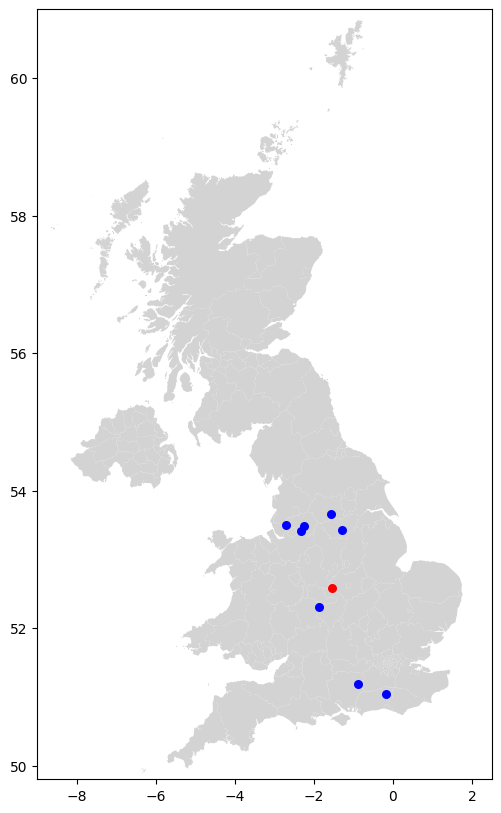

In [330]:
uk_map = gpd.read_file('uk_map/GBR_adm2.shp')

fig, ax = plt.subplots(figsize=(10, 10))
uk_map.plot(ax=ax, color='lightgrey')

gdf = gpd.GeoDataFrame(chosen_items, geometry=gpd.points_from_xy(chosen_items.longitude, chosen_items.latitude))
gdf.plot(ax=ax, marker='o', color='blue', markersize=30)

depot_lat = 52.5761527998474
depot_lon = -1.531357028835363

depot = gpd.GeoDataFrame(geometry=[Point(depot_lon, depot_lat)])
depot.plot(ax=ax, marker='o', color='red', markersize=30)

ax.set_aspect(1.74) # Ratio between latitude and longitude in the UK
ax.set_xlim(-9, 2.5)
ax.set_ylim(49.8, 61)
plt.show()

In [331]:
# The number of nodes is small so we can use a brute force solution.
# The UK is small, so we can approximate GPS coordinates as flat coordinates.
from itertools import permutations
from math import sqrt

points = list(zip(chosen_items['latitude'], chosen_items['longitude']))
points.append((depot_lat, depot_lon))

def total_distance(perm):
    total = 0
    n = len(perm)
    for i in range(n):
        total += sqrt((perm[i][0] - perm[(i+1) % n][0]) ** 2 + (perm[i][1] - perm[(i+1) % n][1]) ** 2)
    return total

best_perm = None
best_dist = float('inf')

for perm in permutations(points):
    dist = total_distance(perm)
    if dist < best_dist:
        best_dist = dist
        best_perm = perm
print(best_perm)
print(best_dist)

((51.187384, -0.887036), (51.040337, -0.184974), (52.5761527998474, -1.531357028835363), (53.428795, -1.280254), (53.659867, -1.560271), (53.482328, -2.248957), (53.415312, -2.323838), (53.499259, -2.703465), (52.301267, -1.882174))
8.158249231365513


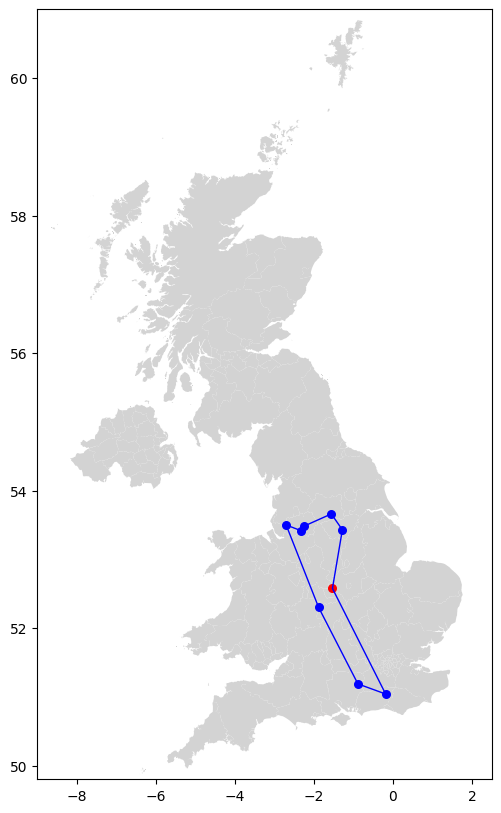

In [332]:
from shapely import LineString

uk_map = gpd.read_file('uk_map/GBR_adm2.shp')

fig, ax = plt.subplots(figsize=(10, 10))
uk_map.plot(ax=ax, color='lightgrey')

gdf = gpd.GeoDataFrame(chosen_items, geometry=gpd.points_from_xy(chosen_items.longitude, chosen_items.latitude))

depot_lat = 52.5761527998474
depot_lon = -1.531357028835363
depot = gpd.GeoDataFrame(geometry=[Point(depot_lon, depot_lat)])

looped_points = best_perm + (best_perm[0],)
line = LineString([Point(lon, lat) for lat, lon in looped_points])
gdf_line = gpd.GeoDataFrame(geometry=[line])

gdf.plot(ax=ax, marker='o', color='blue', markersize=30)
depot.plot(ax=ax, marker='o', color='red', markersize=30)
gdf_line.plot(ax=ax, color='blue', linewidth=1)

ax.set_aspect(1.74) # Ratio between latitude and longitude in the UK
ax.set_xlim(-9, 2.5)
ax.set_ylim(49.8, 61)
plt.show()